<a href="https://colab.research.google.com/github/jamieinfinity/colab_notebooks/blob/master/mnist_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST examples

**NOTES**

Example code showing how to save model and reload to continue training:

- https://stackoverflow.com/questions/45393429/keras-how-to-save-model-and-continue-training
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint


In [0]:
!pip install tensorflow-gpu 


     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 3.8MB 47.9MB/s 
     |████████████████████████████████| 450kB 55.5MB/s 
     |████████████████████████████████| 81kB 14.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exist

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import tensorflow as tf
from tensorflow.keras import layers


In [0]:
print(tf.__version__)

2.0.0


In [0]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


## Classification

### Basic model

In [0]:
NUMPIXELS = 28
NUMFEATURES = NUMPIXELS*NUMPIXELS
BATCHSIZE = 64

In [0]:
# x_train.shape => (60000, 28, 28)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# x.shape => (60000, 28*28)
x_train = x_train[:].reshape(60000, NUMFEATURES).astype('float32') / 255
x_test = x_test[:].reshape(10000, NUMFEATURES).astype('float32') / 255

In [0]:
NUMNODES = 64
NUMCLASSES = len(set(y_train))

inputs = tf.keras.Input(shape=(NUMFEATURES,), name='img')
x = layers.Dense(NUMNODES, activation='relu')(inputs)
x = layers.Dense(NUMNODES, activation='relu')(x)
outputs = layers.Dense(NUMCLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_basic')

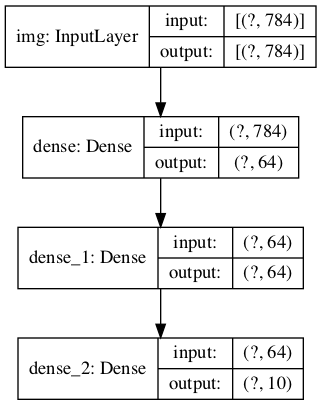

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(loss='sparse_categorical_crossentropy', # sparse form allows us to use non-one-hot-encoded values, e.g. 7
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 4s 80us/sample - loss: 0.3385 - accuracy: 0.9045 - val_loss: 0.1842 - val_accuracy: 0.9452
Epoch 2/5
48000/48000 [==============================] - 3s 59us/sample - loss: 0.1581 - accuracy: 0.9534 - val_loss: 0.1405 - val_accuracy: 0.9590
Epoch 3/5
48000/48000 [==============================] - 3s 68us/sample - loss: 0.1167 - accuracy: 0.9650 - val_loss: 0.1195 - val_accuracy: 0.9661
Epoch 4/5
48000/48000 [==============================] - 3s 66us/sample - loss: 0.0912 - accuracy: 0.9726 - val_loss: 0.1077 - val_accuracy: 0.9696
Epoch 5/5
48000/48000 [==============================] - 3s 68us/sample - loss: 0.0765 - accuracy: 0.9771 - val_loss: 0.1091 - val_accuracy: 0.9704


In [0]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

10000/1 - 0s - loss: 0.0521 - accuracy: 0.9711
Test loss: 0.09869520253157243
Test accuracy: 0.9711


### CNN model (convolutional neural net)

In [0]:
NUMPIXELS = 28
INPUTSHAPE = (NUMPIXELS, NUMPIXELS, 1)

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, NUMPIXELS, NUMPIXELS, 1).astype('float32')/255
x_test = x_test.reshape(10000, NUMPIXELS, NUMPIXELS, 1).astype('float32')/255
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

NUMCLASSES = len(y_train[0])

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
inputs = tf.keras.Input(shape=INPUTSHAPE, name='img2')
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(NUMCLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_cnn')

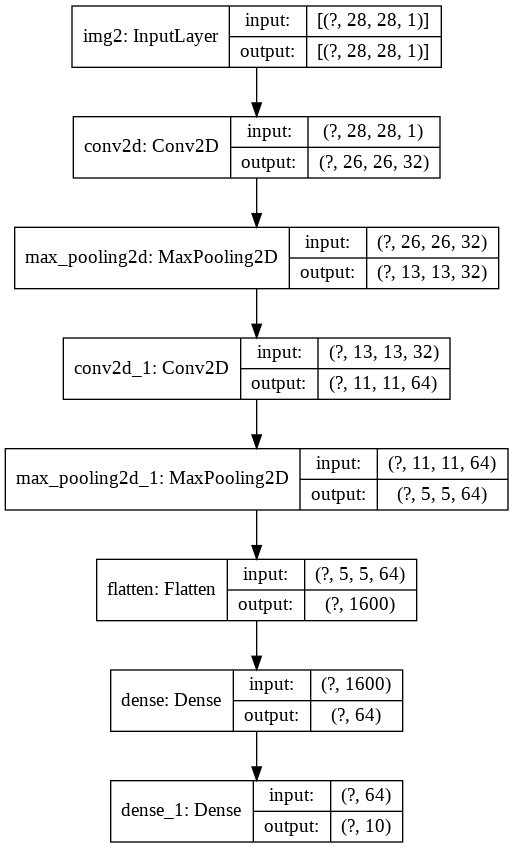

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5
                   )
#                     ,
#                     validation_split=0.2)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 133us/sample - loss: 0.1576 - accuracy: 0.9524
Epoch 2/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0496 - accuracy: 0.9845
Epoch 3/5
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0343 - accuracy: 0.9893
Epoch 4/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0257 - accuracy: 0.9920
Epoch 5/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0195 - accuracy: 0.9942


In [0]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

10000/1 - 1s - loss: 0.0160 - accuracy: 0.9908
Test loss: 0.03184398291490288
Test accuracy: 0.9908


## Autoencoders

**NOTES**
- https://blog.keras.io/building-autoencoders-in-keras.html
- http://www.stokastik.in/understanding-variational-autoencoders/

### Basic autoencoder

In [0]:
NUMPIXELS = 28
INPUTSHAPE = (NUMPIXELS, NUMPIXELS, 1)
LATENTDIM = 2 # number of dimensions of latent space

In [0]:
# define encoder
enc_inputs = tf.keras.Input(shape=INPUTSHAPE, name='enc_input')
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same',
                  activation='relu')(enc_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        padding = 'same')(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same',
                  activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        padding = 'same')(x)
shape_before_flattening = tf.keras.backend.int_shape(x)[1:]
x = layers.Flatten()(x)
enc_outputs = layers.Dense(LATENTDIM, name='enc_output')(x) # activation defaults to linear
enc_model = tf.keras.Model(inputs=enc_inputs, outputs=enc_outputs)


# define decoder
# TODO: examples on the web do this in several different flavors, 
# using Conv2D & UpSampling2D vs Conv2DTranspose with/without Upsampling or pooling.
# Perhaps try some variations to see how they behave
dec_inputs = tf.keras.Input(shape=(LATENTDIM,), name='dec_input')
x = layers.Dense(np.prod(shape_before_flattening))(dec_inputs)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same',
                  activation='relu')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same',
                  activation='relu')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(1, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same',
                  activation='sigmoid')(x)
dec_outputs = x
dec_model = tf.keras.Model(inputs=dec_inputs, outputs=dec_outputs)

model_ae_input = enc_inputs
model_ae_output = dec_model(enc_outputs)

model_ae = tf.keras.Model(model_ae_input, model_ae_output)

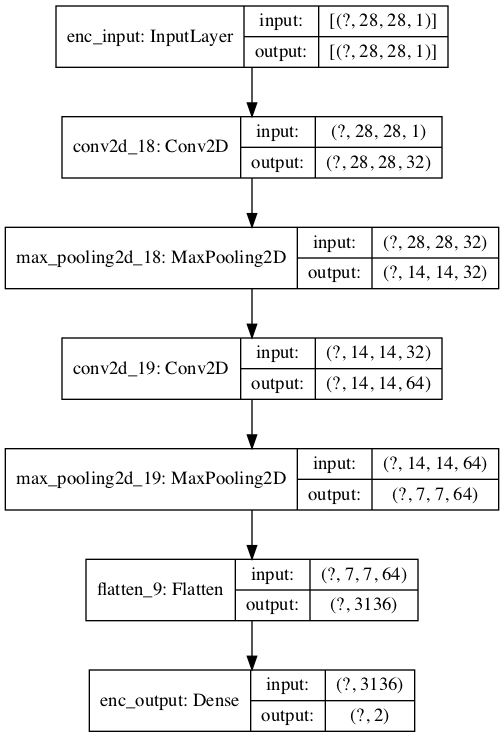

In [0]:
tf.keras.utils.plot_model(enc_model, show_shapes=True)

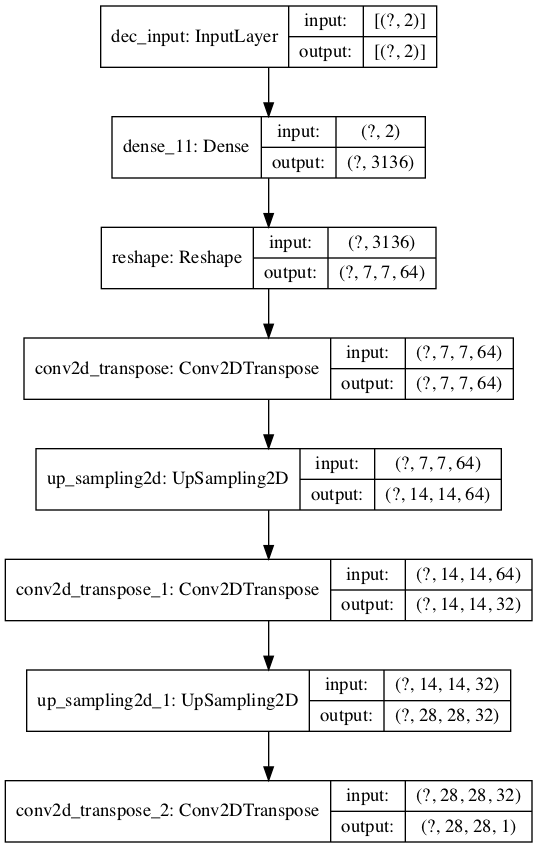

In [0]:
tf.keras.utils.plot_model(dec_model, show_shapes=True)

In [0]:
model_ae.compile(loss='binary_crossentropy',  # you could also use mse or define your own rmse custom loss
                 optimizer=tf.keras.optimizers.Adam())

In [0]:
history = model_ae.fit(x_train, x_train,
                    batch_size=64,
                    epochs=5
                   )

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 93us/sample - loss: 0.2211
Epoch 2/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.1970
Epoch 3/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.1932
Epoch 4/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.1912
Epoch 5/5
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1897
